# Pattern Retrieval

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
# run spark on local mode
# spark = SparkSession.builder.master("local[*]").appName("Big Data").getOrCreate()

# run spark on yarn mode
spark = SparkSession.builder.master("yarn").appName("Big Data").getOrCreate()
sc = spark.sparkContext

In [2]:
# if run on yarn mode, read the file from hdfs
stock_1 = spark.read.csv("hdfs:///user/apple/sample_data/AAPL.csv", inferSchema=True, header=True)

# if run on local mode, read the file from local file system
# stock_1 = spark.read.csv("sample_data/AAPL.csv", inferSchema=True, header=True)

In [3]:
stock_1.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- High: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adjusted Close: double (nullable = true)



In [4]:
from pyspark.sql import functions as F 
close_data = stock_1.select(F.collect_list('Close').alias('Close Price'))
low_data = stock_1.select(F.collect_list('Low').alias('Low Price'))
open_data = stock_1.select(F.collect_list('Open').alias('Open Price'))
volumn_data = stock_1.select(F.collect_list('Volume').alias('Transaction Volume'))
high_data = stock_1.select(F.collect_list('High').alias('High Price'))
adjusted_close_data = stock_1.select(F.collect_list('Adjusted Close').alias('Adjusted Close Price'))

In [5]:
# transform dataframe to array so we can draw the figures
close_price_array = close_data.first()['Close Price']
low_price_array = low_data.first()['Low Price']
open_price_array = open_data.first()['Open Price']
transaction_volume_array = volumn_data.first()['Transaction Volume']
transaction_volume_array = list(map(float, transaction_volume_array))
high_price_array = high_data.first()['High Price']
adjusted_close_price_array = adjusted_close_data.first()['Adjusted Close Price']

In [6]:
date_array = stock_1.select(F.collect_list('Date').alias('Date')).first()['Date']

In [7]:
days = [i for i in range(1, len(date_array) + 1)]

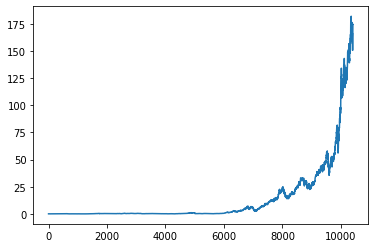

In [8]:
import matplotlib.pyplot as plt
plt.plot(days, close_price_array)

In [9]:
# yarn mode
covid_data = spark.read.csv("hdfs:///user/apple/sample_data/WHO-COVID-19-global-data.csv", inferSchema=True, header=True)

# local mode
# covid_data = spark.read.csv("sample_data/WHO-COVID-19-global-data.csv", inferSchema=True, header=True)

In [10]:
USA_covid_data = covid_data.filter("Country_code = 'US'")

In [11]:
USA_covid_data.printSchema()

root
 |-- Date_reported: string (nullable = true)
 |-- Country_code: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- WHO_region: string (nullable = true)
 |-- New_cases: integer (nullable = true)
 |-- Cumulative_cases: integer (nullable = true)
 |-- New_deaths: integer (nullable = true)
 |-- Cumulative_deaths: integer (nullable = true)



In [12]:
from pyspark.sql.functions import udf
# user defined function to unify the date mode
def changeDateMode(date):
    elements = date.split('-')
    return elements[2] + '-' + elements[1] + '-' + elements[0]
changeDateMode_udf = udf(changeDateMode)
USA_covid_data = USA_covid_data.withColumn('Date_reported', changeDateMode_udf(USA_covid_data.Date_reported))

In [13]:
USA_covid_data = USA_covid_data.select(['Date_reported', 'New_cases', 'New_deaths'])

In [14]:
# user defined function to check negative values
def checkNegative(value):
    if value < 0:
        return -value
    else:
        return value
checkNegative_udf = udf(checkNegative)
from pyspark.sql.types import *
USA_covid_data = USA_covid_data.withColumn('New_cases', checkNegative_udf(USA_covid_data.New_cases).cast(IntegerType()))
USA_covid_data = USA_covid_data.withColumn('New_deaths', checkNegative_udf(USA_covid_data.New_deaths).cast(IntegerType()))

In [15]:
USA_covid_data.printSchema()

root
 |-- Date_reported: string (nullable = true)
 |-- New_cases: integer (nullable = true)
 |-- New_deaths: integer (nullable = true)



In [16]:
covid_date_array = USA_covid_data.select(F.collect_list('Date_reported').alias('Date')).first()['Date']

In [17]:
# find the first day the covid data was reported
first_day_index = 0
for i in range(0, 3):
    if covid_date_array[i] in date_array:
        first_day_index = date_array.index(covid_date_array[i])
        break
print(first_day_index)

9848


In [18]:
# find the final day the covid data was reported
final_day_index = 0
for i in range(1, 4):
    if covid_date_array[len(covid_date_array) - i] in date_array:
        final_day_index = date_array.index(covid_date_array[len(covid_date_array) - i])
        break
print(final_day_index)

10410


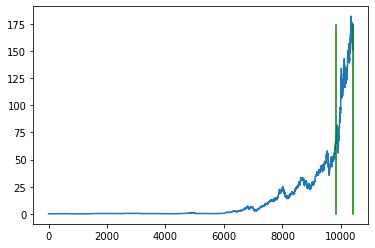

In [19]:
plt.plot(days, close_price_array, [first_day_index] * 175, [i for i in range(0, 175)], 'green', [final_day_index] * 175, [i for i in range(0, 175)], 'green')
plt.savefig('AAPL_price.png')

In [20]:
import numpy as np
# calculate dtw-based distance between two time-series
def cal_dtw_distance(ts_a, ts_b):
    d=lambda x, y: abs(x - y)

    ts_a, ts_b = np.array(ts_a), np.array(ts_b)
    M, N = len(ts_a), len(ts_b)
    cost = np.inf * np.ones((M, N))

    cost[0, 0] = d(ts_a[0], ts_b[0])
    for i in range(1, M):
        cost[i, 0] = cost[i - 1, 0] + d(ts_a[i], ts_b[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j - 1] + d(ts_a[0], ts_b[j])

    # dynamic programming
    for i in range(1, M):
        for j in range(1, N):
            choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
            cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

    return cost[-1, -1]

In [21]:
#define the length of the pattern and define the step in sliding windows
date_gap = 365
step = 180
close_price_array_window = [close_price_array[i:i+date_gap] for i in range(int(first_day_index*0.5), first_day_index - date_gap, step)]

In [22]:
# z_score normalization
def Z_ScoreNormalization(x,mu,sigma):
    x = (x - mu) / sigma;
    return x;
close_price_array_window_norm = []
for i in range(0, len(close_price_array_window)):
    mu = np.average(close_price_array_window[i])
    sigma = np.std(close_price_array_window[i])
    close_price_array_window_norm.append(Z_ScoreNormalization(close_price_array_window[i], mu, sigma))

In [23]:
close_price_when_covid = close_price_array[first_day_index: first_day_index + date_gap]
close_price_when_covid_norm = Z_ScoreNormalization(close_price_when_covid,
                                                  np.average(close_price_when_covid),
                                                  np.std(close_price_when_covid))

In [24]:
# using dtw and sliding windows to calculate all dtw-based distance
dtws = []
for i in range(0, len(close_price_array_window_norm)):
    dtw = cal_dtw_distance(close_price_array_window_norm[i], close_price_when_covid_norm)
    dtws.append(dtw)

In [25]:
# sort the dtw distances
sort_index = np.argsort(dtws)
min_index = sort_index[0]

In [26]:
print(dtws[min_index])

53.397846477395774


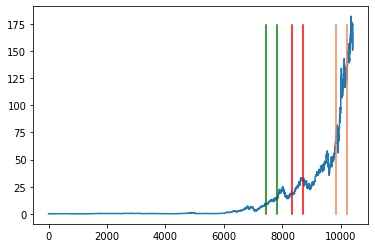

In [27]:
# visualize the current pattern and two most similar patterns
plt.plot(days, close_price_array)
plt.plot([first_day_index] * 175, [i for i in range(0, 175)], color='coral')
plt.plot([first_day_index + date_gap] * 175, [i for i in range(0, 175)], color='coral')
plt.plot([int(first_day_index*0.5) + min_index*step] * 175, [i for i in range(0,175)], color='green')
plt.plot([int(first_day_index*0.5) + min_index*step + date_gap] * 175, [i for i in range(0,175)], color='green')
plt.plot([int(first_day_index*0.5) + sort_index[1]*step] * 175, [i for i in range(0,175)], color='red')
plt.plot([int(first_day_index*0.5) + sort_index[1]*step + date_gap] * 175, [i for i in range(0,175)], color='red')
plt.savefig('similar_pattern.png')

# Feature Extraction


In [28]:
# min_max normalization
def min_max_norm(x):
    min_value = min(x)
    max_value = max(x)
    x = np.array(x)
    return (x - min_value)/(max_value - min_value)

In [29]:
# get all normalized features for the two similar patterns
most_low_price_array_norm = min_max_norm(low_price_array[int(first_day_index*0.5) + (step * sort_index[0]): int(first_day_index*0.5) + (step * sort_index[0]) + date_gap])
second_low_price_array_norm = min_max_norm(low_price_array[int(first_day_index*0.5) + (step * sort_index[1]): int(first_day_index*0.5) + (step * sort_index[1]) + date_gap])

most_high_price_array_norm = min_max_norm(high_price_array[int(first_day_index*0.5) + (step * sort_index[0]): int(first_day_index*0.5) + (step * sort_index[0]) + date_gap])
second_high_price_array_norm = min_max_norm(high_price_array[int(first_day_index*0.5) + (step * sort_index[1]): int(first_day_index*0.5) + (step * sort_index[1]) + date_gap])

most_open_price_array_norm = min_max_norm(open_price_array[int(first_day_index*0.5) + (step * sort_index[0]): int(first_day_index*0.5) + (step * sort_index[0]) + date_gap])
second_open_price_array_norm = min_max_norm(open_price_array[int(first_day_index*0.5) + (step * sort_index[1]): int(first_day_index*0.5) + (step * sort_index[1]) + date_gap])

most_transaction_volume_array_norm = min_max_norm(transaction_volume_array[int(first_day_index*0.5) + (step * sort_index[0]): int(first_day_index*0.5) + (step * sort_index[0]) + date_gap])
second_transaction_volume_array_norm = min_max_norm(transaction_volume_array[int(first_day_index*0.5) + (step * sort_index[1]): int(first_day_index*0.5) + (step * sort_index[1]) + date_gap])

most_adjusted_close_price_array_norm = min_max_norm(adjusted_close_price_array[int(first_day_index*0.5) + (step * sort_index[0]): int(first_day_index*0.5) + (step * sort_index[0]) + date_gap])
second_adjusted_close_price_array_norm = min_max_norm(adjusted_close_price_array[int(first_day_index*0.5) + (step * sort_index[1]): int(first_day_index*0.5) + (step * sort_index[1]) + date_gap])

most_close_price_array = close_price_array[int(first_day_index*0.5) + (step * sort_index[0]): int(first_day_index*0.5) + (step * sort_index[0]) + date_gap]
second_close_price_array = close_price_array[int(first_day_index*0.5) + (step * sort_index[1]): int(first_day_index*0.5) + (step * sort_index[1]) + date_gap]

low_price_array_norm = min_max_norm(low_price_array)
high_price_array_norm = min_max_norm(high_price_array)
open_price_array_norm = min_max_norm(open_price_array)
transaction_volume_array_norm = min_max_norm(transaction_volume_array)
adjusted_close_price_array_norm = min_max_norm(adjusted_close_price_array)

In [30]:
most_datas = np.stack((most_close_price_array, most_low_price_array_norm, most_open_price_array_norm, most_transaction_volume_array_norm, most_high_price_array_norm, most_adjusted_close_price_array_norm), axis = 1)
second_datas = np.stack((second_close_price_array, second_low_price_array_norm, second_open_price_array_norm, second_transaction_volume_array_norm, second_high_price_array_norm, second_adjusted_close_price_array_norm), axis = 1)
datas = np.stack((close_price_array, low_price_array_norm, open_price_array_norm, transaction_volume_array_norm, high_price_array_norm, adjusted_close_price_array_norm), axis = 1)

In [31]:
import pandas as pd
most_df = pd.DataFrame(most_datas, columns=['close_price', 'low_price', 'open_price', 'transaction_volume', 'high_price', 'adjusted_close_price'])
second_df = pd.DataFrame(second_datas, columns=['close_price', 'low_price', 'open_price', 'transaction_volume', 'high_price', 'adjusted_close_price'])
df = pd.DataFrame(datas, columns=['close_price', 'low_price', 'open_price', 'transaction_volume', 'high_price', 'adjusted_close_price'])

In [32]:
most_sparkdf = spark.createDataFrame(most_df)
second_sparkdf = spark.createDataFrame(second_df)

In [33]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, VectorIndexer

In [34]:
# the linear regression needed for stepwise regression algorithm
def train_and_test(sparkdf, inputCols, target):
    assembler = VectorAssembler(inputCols=inputCols, outputCol='features')
    output = assembler.transform(sparkdf)
    label_features = output.select('features', target).toDF('features', 'label')
    train_data = pd.DataFrame(label_features.toPandas()[0:int(date_gap*0.8)], columns=['features', 'label'])
    train_data = spark.createDataFrame(train_data)
    test_data = pd.DataFrame(label_features.toPandas()[int(date_gap*0.8):], columns=['features', 'label'])
    test_data = spark.createDataFrame(test_data)
    lr = LinearRegression()
    lrModel = lr.fit(train_data)
    test_result = lrModel.evaluate(test_data)
    print("R2: {}".format(test_result.r2))
    return test_result.r2

In [35]:
# get R2 for all determinants of the first similar pattern
most_test_results = []
inputCols = ['low_price', 'open_price', 'transaction_volume', 'high_price']
target = 'close_price'
for i in range(len(inputCols)):
    most_test_results.append(train_and_test(most_sparkdf, inputCols[i:i+1], target))

R2: 0.8992395567266209
R2: 0.8364136421814379
R2: -25.815298066489166
R2: 0.9433493201132435


In [36]:
# get R2 for all determinants of the second similar pattern
second_test_results = []
inputCols = ['low_price', 'open_price', 'transaction_volume', 'high_price']
target = 'close_price'
for i in range(len(inputCols)):
    second_test_results.append(train_and_test(second_sparkdf, inputCols[i:i+1], target))

R2: 0.8484108393529695
R2: 0.5910763203633635
R2: -161.26422915477633
R2: 0.8224563292983695


In [37]:
# get the best determinant for the first similar pattern
most_best_determinant = inputCols[most_test_results.index(max(most_test_results))]

In [38]:
most_best_determinant

'high_price'

In [39]:
# get the best determinant for the second similar pattern
second_best_determinant = inputCols[second_test_results.index(max(second_test_results))]

In [40]:
second_best_determinant

'low_price'

In [41]:
# stepwise regression for the first similar pattern
inputCols = ['low_price', 'open_price', 'transaction_volume', 'high_price', 'adjusted_close_price']
most_determinants = []
most_determinants.append(most_best_determinant)
inputCols.remove(most_best_determinant)
most_result = max(most_test_results)
for i in range(len(inputCols)):
    most_determinants.append(inputCols[i])
    temp_result = train_and_test(most_sparkdf, most_determinants, target)
    if temp_result < most_result:
        most_determinants.remove(inputCols[i])
    else:
        most_result = temp_result

R2: 0.9487211890509566
R2: 0.970547254982927
R2: 0.9718201134946675
R2: 0.9999999999881609


In [42]:
most_determinants

['high_price',
 'low_price',
 'open_price',
 'transaction_volume',
 'adjusted_close_price']

In [43]:
# stepwise regression for the second similar pattern
inputCols = ['low_price', 'open_price', 'transaction_volume', 'high_price', 'adjusted_close_price']
second_determinants = []
second_determinants.append(second_best_determinant)
inputCols.remove(second_best_determinant)
second_result = max(second_test_results)
for i in range(len(inputCols)):
    second_determinants.append(inputCols[i])
    temp_result = train_and_test(second_sparkdf, second_determinants, target)
    if temp_result < second_result:
        second_determinants.remove(inputCols[i])
    else:
        second_result = temp_result

R2: 0.8496018646385696
R2: 0.8568141113279688
R2: 0.9500492854613464
R2: 0.9693887981127494


In [44]:
second_determinants

['low_price',
 'open_price',
 'transaction_volume',
 'high_price',
 'adjusted_close_price']

In [45]:
# final determinants by getting intersection
determinants = list(set(most_determinants).intersection(set(second_determinants)))
determinants

['high_price',
 'low_price',
 'open_price',
 'adjusted_close_price',
 'transaction_volume']

In [46]:
determinants_final = []
if 'high_price' in determinants:
    determinants_final.append('High')
if 'low_price' in determinants:
    determinants_final.append('Low')
if 'open_price' in determinants:
    determinants_final.append('Open')
if 'transaction_volume' in determinants:
    determinants_final.append('Volume')
if 'adjusted_close_price' in determinants:
    determinants_final.append('Adjusted Close')
determinants_final.append('New_cases')
determinants_final.append('New_deaths')
determinants_final.append('Close')

In [47]:
# join USA_covid data and stock data by the same date
final_data = stock_1.join(USA_covid_data, stock_1.Date==USA_covid_data.Date_reported).select(determinants_final)
determinants_final.remove('Close')
determinants_final.remove('New_cases')
determinants_final.remove('New_deaths')

# Data Preprocess for Prediction (without offset)


In [48]:
# seperate the data into three parts
final_data_df = final_data.toPandas()
interval = (int)(final_data.count()/3)

In [49]:
# !! only run this code or code above at a time
# train data with consideration of COVID
final_train_data_feature = final_data_df[determinants_final].loc[0: 0 + interval]
final_train_data_target = final_data_df[['Close']].loc[0: 0 + interval]

newindex = [i for i in range(0, len(final_train_data_feature))]
final_train_data_feature.index = newindex
final_train_data_target.index = newindex

final_train_data = final_train_data_feature
final_train_data.insert(loc=0, column='close_price', value=final_train_data_target['Close'])
final_train_data.insert(loc=0, column='index', value=newindex)

final_train_data.to_csv('final_train_data.csv', index=False)

In [50]:
final_test_data_feature = final_data_df[determinants_final].loc[0 + interval: 0 + 2*interval]
final_test_data_target = final_data_df[['Close']].loc[0 + interval: 0 + 2*interval]
covid_test_data_New_cases_df = final_data_df[['New_cases']].loc[0 + interval: 0 + 2*interval]
covid_test_data_New_deaths_df = final_data_df[['New_deaths']].loc[0 + interval: 0 + 2*interval]
covid_test_data_New_cases_array = covid_test_data_New_cases_df.values
covid_test_data_New_deaths_array = covid_test_data_New_deaths_df.values

final_test_data_feature.index = newindex
final_test_data_target.index = newindex

final_test_data = final_test_data_feature
final_test_data.insert(loc=0, column='close_price', value=final_test_data_target['Close'])
final_test_data.insert(loc=0, column='index', value=newindex)
final_test_data.to_csv('final_test_data.csv', index=False)

In [51]:
final_predict_data_feature = final_data_df[determinants_final].loc[0 + 2*interval:]
final_predict_data_target = final_data_df[['Close']].loc[0 + 2*interval:]

newindex1 = [i for i in range(0, len(final_predict_data_feature))]
final_predict_data_feature.index = newindex1
final_predict_data_target.index = newindex1

final_predict_data = final_predict_data_feature
final_predict_data.insert(loc=0, column='close_price', value=final_predict_data_target['Close'])
final_predict_data.insert(loc=0, column='index', value=newindex1)
final_predict_data.to_csv('final_predict_data.csv', index=False)

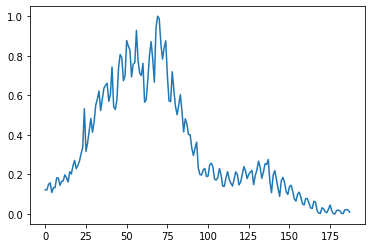

In [52]:
covid_test_data_New_cases_array = min_max_norm(covid_test_data_New_cases_array)
plt.plot(covid_test_data_New_cases_array)

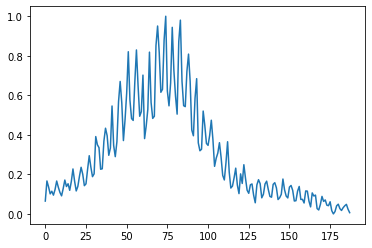

In [53]:
covid_test_data_New_deaths_array = min_max_norm(covid_test_data_New_deaths_array)
plt.plot(covid_test_data_New_deaths_array)

# Prediction with LSTM

In [54]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
df=pd.read_csv("final_train_data.csv",index_col=[0])
df_test = pd.read_csv("final_test_data.csv", index_col=[0])

In [55]:
df_for_training = df
df_for_testing = df_test

In [56]:
df_for_training_feature = df_for_training[determinants_final]
df_for_training_label = df_for_training[['close_price']]

In [57]:
df_for_testing_feature = df_for_testing[determinants_final]
df_for_testing_label = df_for_testing[['close_price']]

In [58]:
scaler_feature = MinMaxScaler(feature_range=(0,1))
scaler_label = MinMaxScaler(feature_range=(0,1))
df_for_training_feature_scaled = scaler_feature.fit_transform(df_for_training_feature)
df_for_testing_feature_scaled=scaler_feature.transform(df_for_testing_feature)

df_for_training_label_scaled = scaler_label.fit_transform(df_for_training_label)
df_for_testing_label_scaled = scaler_label.transform(df_for_testing_label)

In [59]:
df_for_training_scaled = np.column_stack((df_for_training_label_scaled, df_for_training_feature_scaled))
df_for_testing_scaled = np.column_stack((df_for_testing_label_scaled, df_for_testing_feature_scaled))

In [60]:
# reads data for prediction
df_predict = pd.read_csv('final_predict_data.csv', index_col=[0])
df_predict_feature = df_predict[determinants_final]
df_predict_label = df_predict[['close_price']]

In [61]:
# scaling for prediction data
df_for_predict_feature_scaled = scaler_feature.transform(df_predict_feature)
df_for_predict_label_scaled = scaler_label.transform(df_predict_label)
df_for_predict_scaled = np.column_stack((df_for_predict_label_scaled, df_for_predict_feature_scaled))

In [62]:
look_back=10 # Timestep of LSTM for each iteration (How many days to look back on)
def createXY(dataset,n_past): 
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]]) # X items at a given time (t) and Y items at the next time (t + 1)
            dataY.append(dataset[i,0]) 
    return np.array(dataX),np.array(dataY) 

trainX,trainY=createXY(df_for_training_scaled,look_back) 
testX,testY=createXY(df_for_testing_scaled,look_back)

In [63]:
scaler_label.inverse_transform(trainY.reshape(len(trainY), 1))

array([[ 79.68250275],
       [ 79.14250183],
       [ 79.42500305],
       [ 79.80750275],
       [ 79.57749939],
       [ 77.23750305],
       [ 79.42250061],
       [ 81.08499908],
       [ 80.96749878],
       [ 77.37750244],
       [ 77.16500092],
       [ 79.71250153],
       [ 80.36250305],
       [ 81.30249786],
       [ 80.00749969],
       [ 80.38749695],
       [ 79.90249634],
       [ 81.80000305],
       [ 81.21749878],
       [ 81.23750305],
       [ 79.75      ],
       [ 80.90499878],
       [ 80.07499695],
       [ 78.26249695],
       [ 74.54499817],
       [ 72.01999664],
       [ 73.16249847],
       [ 68.37999725],
       [ 68.33999634],
       [ 74.70249939],
       [ 72.33000183],
       [ 75.68499756],
       [ 73.23000336],
       [ 72.25749969],
       [ 66.54250336],
       [ 71.33499908],
       [ 68.85749817],
       [ 62.05749893],
       [ 69.49250031],
       [ 60.55250168],
       [ 63.21500015],
       [ 61.66749954],
       [ 61.19499969],
       [ 57

In [64]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(10,len(determinants_final))))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [20, 50],
              'epochs' : [100],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv=2,
                            n_jobs=-1)

In [65]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/100
9/9 [==============================] - 3s 75ms/step - loss: 0.0844 - val_loss: 0.0092
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0210 - val_loss: 0.0227
Epoch 3/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0103 - val_loss: 0.0326
Epoch 4/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0072 - val_loss: 0.0043
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 6/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 7/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 8/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 0.0027
Epoch 9/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0058 - val_loss: 0.0027
Epoch 10/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 11/100
9/9 [=

Epoch 84/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 85/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 86/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 87/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 88/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 89/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 90/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 91/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 92/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 93/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 94/1

In [66]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 100, 'optimizer': 'adam'}

In [67]:
# get trained model
my_model=grid_search.best_estimator_.model

# validation predit with test data
prediction=my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.7855294 ]
 [0.8006533 ]
 [0.8044927 ]
 [0.8020438 ]
 [0.7832035 ]
 [0.7655634 ]
 [0.749864  ]
 [0.7348295 ]
 [0.7226344 ]
 [0.7211605 ]
 [0.73107743]
 [0.72315323]
 [0.7200123 ]
 [0.70221364]
 [0.6858878 ]
 [0.6804622 ]
 [0.69260836]
 [0.72298115]
 [0.7471361 ]
 [0.7630108 ]
 [0.7609545 ]
 [0.76719344]
 [0.7770269 ]
 [0.78362316]
 [0.7848474 ]
 [0.7837946 ]
 [0.7805359 ]
 [0.7755038 ]
 [0.77033293]
 [0.7583507 ]
 [0.74396276]
 [0.7416295 ]
 [0.7477774 ]
 [0.75859886]
 [0.7819703 ]
 [0.804618  ]
 [0.8229844 ]
 [0.8293044 ]
 [0.83290684]
 [0.838223  ]
 [0.83327705]
 [0.8225122 ]
 [0.81193733]
 [0.8126113 ]
 [0.8287443 ]
 [0.8484986 ]
 [0.8692986 ]
 [0.87428415]
 [0.8690343 ]
 [0.8842749 ]
 [0.8988202 ]
 [0.9067066 ]
 [0.9213284 ]
 [0.930183  ]
 [0.931906  ]
 [0.92067325]
 [0.8949484 ]
 [0.88070345]
 [0.85793895]
 [0.8575521 ]
 [0.8662857 ]
 [0.8633815 ]
 [0.86152595]
 [0.8670684 ]
 [0.8693093 ]
 [0.86361605]
 [0.8598283 ]
 [0.8666378 ]
 [0.9000075 ]
 [0.93311334]
 [0.9710

In [68]:
# retrive result
pred = scaler_label.inverse_transform(prediction)
original = scaler_label.inverse_transform(testY.reshape(len(testY), 1))

In [69]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [[117.43252 ]
 [118.61351 ]
 [118.913315]
 [118.72209 ]
 [117.25089 ]
 [115.873436]
 [114.6475  ]
 [113.473495]
 [112.52121 ]
 [112.40612 ]
 [113.180504]
 [112.56172 ]
 [112.31645 ]
 [110.926605]
 [109.65176 ]
 [109.22809 ]
 [110.17655 ]
 [112.54829 ]
 [114.43449 ]
 [115.6741  ]
 [115.51353 ]
 [116.00071 ]
 [116.76858 ]
 [117.28367 ]
 [117.379265]
 [117.29706 ]
 [117.042595]
 [116.64965 ]
 [116.245865]
 [115.3102  ]
 [114.18668 ]
 [114.004486]
 [114.484566]
 [115.32959 ]
 [117.1546  ]
 [118.9231  ]
 [120.35729 ]
 [120.85081 ]
 [121.1321  ]
 [121.54723 ]
 [121.16102 ]
 [120.32042 ]
 [119.49465 ]
 [119.54728 ]
 [120.80706 ]
 [122.349625]
 [123.97385 ]
 [124.36316 ]
 [123.95321 ]
 [125.14331 ]
 [126.27912 ]
 [126.89494 ]
 [128.03673 ]
 [128.72816 ]
 [128.8627  ]
 [127.985565]
 [125.97678 ]
 [124.864426]
 [123.08681 ]
 [123.056595]
 [123.73858 ]
 [123.511795]
 [123.366905]
 [123.7997  ]
 [123.974686]
 [123.53011 ]
 [123.23434 ]
 [123.766075]
 [126.371826]
 [128.95699 ]
 [131

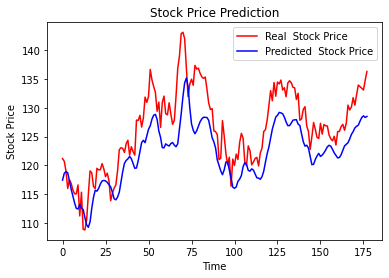

In [70]:
import matplotlib.pyplot as plt
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

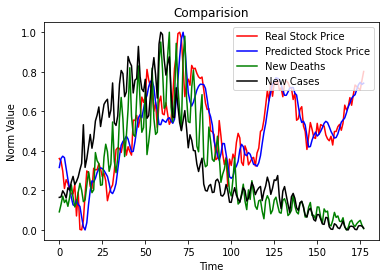

In [71]:
original_norm = min_max_norm(original)
pred_norm = min_max_norm(pred)
plt.plot(original_norm, color = 'red', label = 'Real Stock Price')
plt.plot(pred_norm, color = 'blue', label = 'Predicted Stock Price')
plt.plot(covid_test_data_New_deaths_array[10:], color = 'green', label = 'New Deaths')
plt.plot(covid_test_data_New_cases_array[10:], color = 'black', label = 'New Cases')
plt.title('Comparision')
plt.xlabel('Time')
plt.ylabel('Norm Value')
plt.legend()
plt.show()

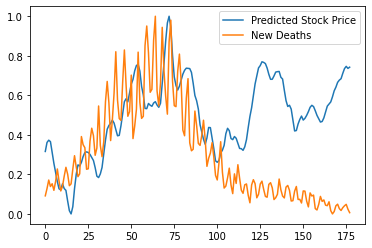

In [72]:
plt.plot(pred_norm, label="Predicted Stock Price")
plt.plot(covid_test_data_New_deaths_array[10:], label="New Deaths")
plt.legend()
plt.savefig('death_pred.png')

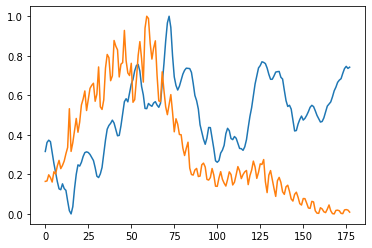

In [73]:
plt.plot(pred_norm, label="Predicted Stock Price")
plt.plot(covid_test_data_New_cases_array[10:], label="New C")
plt.savefig('case_pred.png')

In [74]:
import math
def computeCorrelation(X, Y):
    xBar = np.mean(X)
    yBar = np.mean(Y)
    SSR = 0
    varX = 0
    varY = 0
    for i in range(0 , len(X)):
        diffXXBar = X[i] - xBar
        diffYYBar = Y[i] - yBar
        SSR += (diffXXBar * diffYYBar)
        varX +=  diffXXBar**2
        varY += diffYYBar**2
    
    SST = math.sqrt(varX * varY)
    
    print ("R-Squared:", (SSR / SST)**2)

computeCorrelation(pred, original)

R-Squared: [0.83836481]


### Prediction

In [75]:
predX,predY=createXY(df_for_predict_scaled,10)

In [76]:
# run prediciton
predictionResult=my_model.predict(predX)

predInversed = scaler_label.inverse_transform(predictionResult)
originalInversed = scaler_label.inverse_transform(predY.reshape(len(predY), 1))

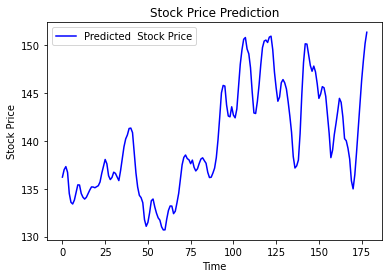

In [77]:
plt.plot(predInversed, color = 'blue', label = 'Predicted  Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()